# TEST 1a: 2 Separate Sinusoids Test - Scattered Sampling

## Setup Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import gpytorch
from sklearn.datasets import make_blobs

# Define USER parameters for dataset
low_freq = 0.1 # Hz
high_freq = 100 # Hz
n_samples = 500
num_clusters = 6

# Generate clustered input samples
clustered_input_data, _ = make_blobs(n_samples=n_samples, 
                                     centers=num_clusters, 
                                     cluster_std=0.1, 
                                     center_box=(-10, 10), 
                                     random_state=42)
x_train = torch.Tensor(clustered_input_data[:, 0]) # take the first column of data generated

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.1, n_samples)
y1_low_freq = torch.sin(2 * torch.pi * low_freq * x_train) + torch.Tensor(gw_noise)
y2_high_freq = torch.sin(2 * torch.pi * high_freq * x_train) + torch.Tensor(gw_noise)
y_train = torch.stack([y1_low_freq, y2_high_freq], -1)

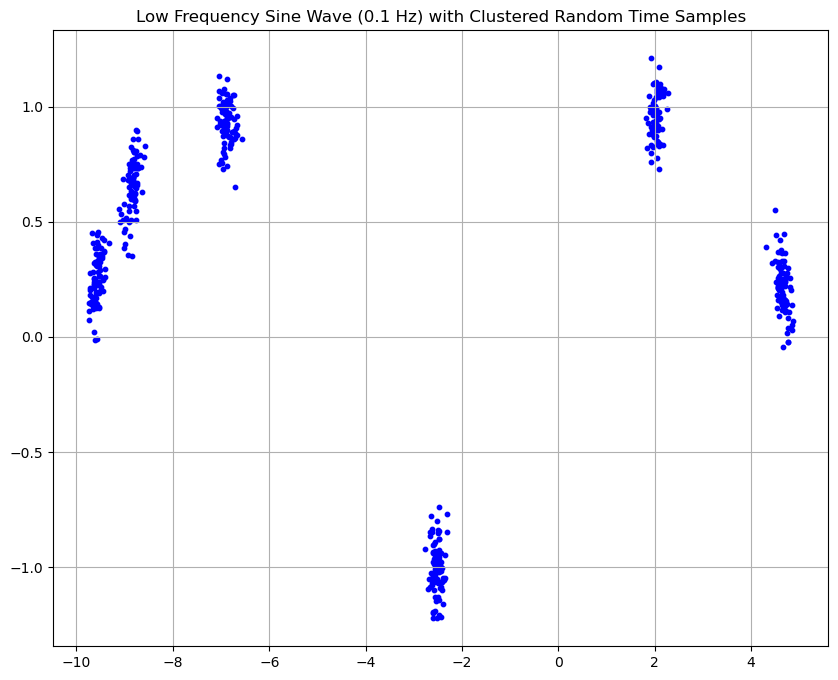

In [2]:
# Plot low frequency sine wave
plt.figure(figsize=(10, 8))
plt.scatter(x_train, y1_low_freq, color='blue', s=10)
plt.title(f'Low Frequency Sine Wave ({low_freq} Hz) with Clustered Random Time Samples')
plt.grid(True)
plt.show()

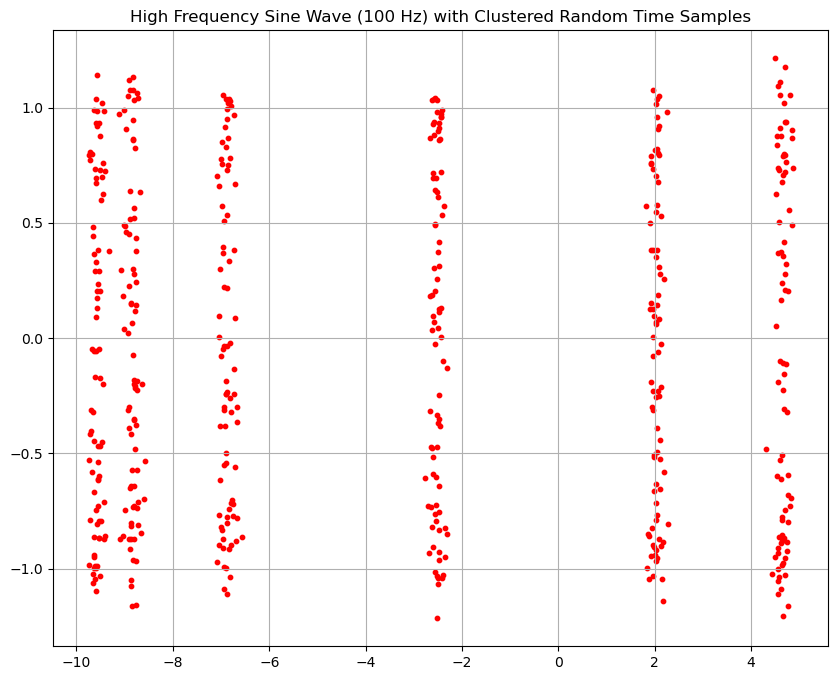

In [3]:
# Plot high frequency sine wave in a separate figure
plt.figure(figsize=(10, 8))
plt.scatter(x_train, y2_high_freq, color='red', s=10)
plt.title(f'High Frequency Sine Wave ({high_freq} Hz) with Clustered Random Time Samples')
plt.grid(True)
plt.show()

## Define the Batch GP model

In [4]:
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([2]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([2])),
            batch_shape=torch.Size([2])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model_sin1 = BatchIndependentMultitaskGPModel(x_train, y_train, likelihood)

## Train the Batch GP model

In [5]:
# Find optimal model hyperparameters
model_sin1.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model_sin1.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_sin1)

training_epochs = 500
for i in range(training_epochs):
    optimizer.zero_grad()
    output = model_sin1(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_epochs, loss.item()))
    optimizer.step()

Iter 1/500 - Loss: 1.200
Iter 2/500 - Loss: 1.170
Iter 3/500 - Loss: 1.143
Iter 4/500 - Loss: 1.113
Iter 5/500 - Loss: 1.079
Iter 6/500 - Loss: 1.056
Iter 7/500 - Loss: 1.018
Iter 8/500 - Loss: 0.995
Iter 9/500 - Loss: 0.970
Iter 10/500 - Loss: 0.939
Iter 11/500 - Loss: 0.917
Iter 12/500 - Loss: 0.889
Iter 13/500 - Loss: 0.861
Iter 14/500 - Loss: 0.850
Iter 15/500 - Loss: 0.825
Iter 16/500 - Loss: 0.807
Iter 17/500 - Loss: 0.792
Iter 18/500 - Loss: 0.774
Iter 19/500 - Loss: 0.748
Iter 20/500 - Loss: 0.738
Iter 21/500 - Loss: 0.717
Iter 22/500 - Loss: 0.694
Iter 23/500 - Loss: 0.679
Iter 24/500 - Loss: 0.651
Iter 25/500 - Loss: 0.638
Iter 26/500 - Loss: 0.610
Iter 27/500 - Loss: 0.584
Iter 28/500 - Loss: 0.561
Iter 29/500 - Loss: 0.535
Iter 30/500 - Loss: 0.527
Iter 31/500 - Loss: 0.499
Iter 32/500 - Loss: 0.469
Iter 33/500 - Loss: 0.437
Iter 34/500 - Loss: 0.432
Iter 35/500 - Loss: 0.400
Iter 36/500 - Loss: 0.374
Iter 37/500 - Loss: 0.373
Iter 38/500 - Loss: 0.348
Iter 39/500 - Loss: 0

## Make predictions with the Batch GP model and Plot it

In [6]:
# Set into eval mode
model_sin1.eval()
likelihood.eval()

# Make predictions
# IMP NOTE:    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x_test = torch.linspace(-10, 10, 1000)
    predictions = likelihood(model_sin1(x_test))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

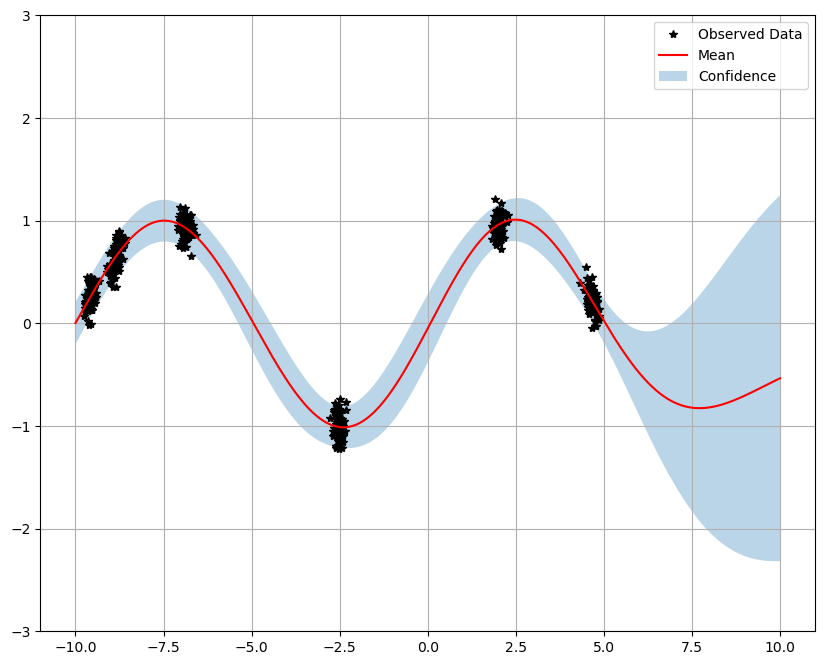

In [7]:
plt.figure(figsize=(10, 8))
plt.plot(x_train.detach().numpy(), y_train[:, 0].detach().numpy(), 'k*')
plt.plot(x_test.numpy(), mean[:, 0].numpy(), 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.3)
plt.ylim([-3, 3])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

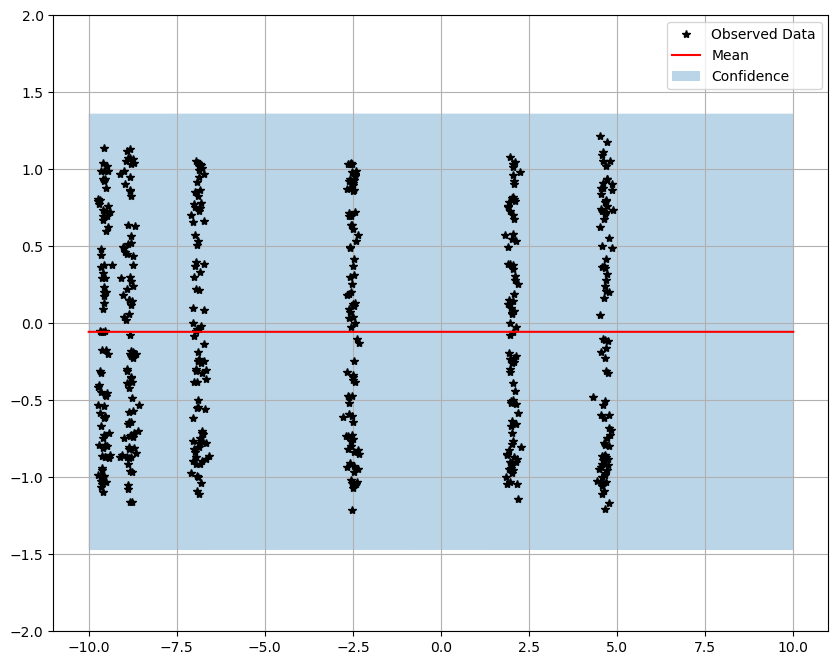

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(x_train.detach().numpy(), y_train[:, 1].detach().numpy(), 'k*')
plt.plot(x_test.numpy(), mean[:, 1].numpy(), 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.3)
plt.ylim([-2, 2])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

## View Batch GP Model Parameters

In [9]:
for name, param in model_sin1.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter value: {param}\n")

Parameter name: likelihood.raw_task_noises
Parameter value: Parameter containing:
tensor([-5.4135, -0.4423], requires_grad=True)

Parameter name: likelihood.raw_noise
Parameter value: Parameter containing:
tensor([-5.2303], requires_grad=True)

Parameter name: mean_module.raw_constant
Parameter value: Parameter containing:
tensor([-0.1963, -0.0555], requires_grad=True)

Parameter name: covar_module.raw_outputscale
Parameter value: Parameter containing:
tensor([ 0.4271, -9.9518], requires_grad=True)

Parameter name: covar_module.base_kernel.raw_lengthscale
Parameter value: Parameter containing:
tensor([[[2.7815]],

        [[3.5877]]], requires_grad=True)



## Define and Fit the BLR Model

In [10]:
from sklearn.linear_model import BayesianRidge
from sklearn.multioutput import MultiOutputRegressor
import numpy as np

n_order = 5 # order for polynomial features
x_test = np.linspace(-10, 10, 1000)

# Create datasets with polynomial features
x_train_blr = np.vander(x_train.numpy(), n_order + 1, increasing=True)
x_test_blr = np.vander(x_test, n_order + 1, increasing=True)
blr_model_sin1 = MultiOutputRegressor(BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True))

# Fit the model
blr_model_sin1.fit(x_train_blr, y_train.numpy())

MultiOutputRegressor(estimator=BayesianRidge(compute_score=True,
                                             fit_intercept=False, tol=1e-06))

## Make predictions with the BLR model and Plot it

In [11]:
# NOTE: Multi-output regressor doesn't support return_std, so have to pass test data into model through a loop
# Collect the mean and standard deviation for each output
y_means = np.zeros((x_test_blr.shape[0], 2))
y_stds = np.zeros((x_test_blr.shape[0], 2))

# Pass the test data through the model
for i, model in enumerate(blr_model_sin1.estimators_):
    y_mean, y_std = model.predict(x_test_blr, return_std=True)
    y_means[:, i] = y_mean
    y_stds[:, i] = y_std

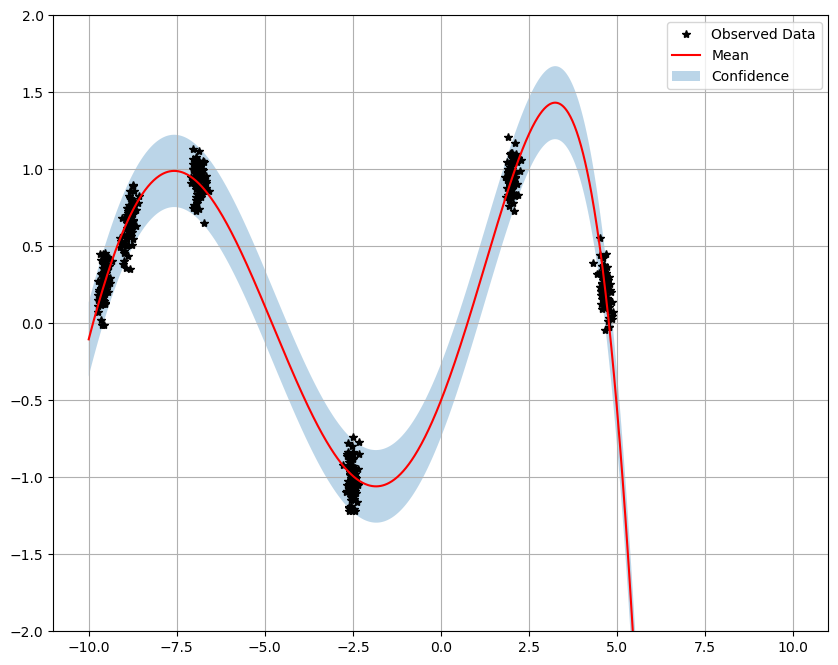

In [12]:
# Plot y1 (low freq sine wave) 
plt.figure(figsize=(10, 8))
plt.plot(x_train.numpy(), y_train[:, 0].numpy(), 'k*')
plt.plot(x_test, y_means[:, 0], 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test, y_means[:, 0] - 2 * y_stds[:, 0], y_means[:, 0] + 2 * y_stds[:, 0], alpha=0.3)
plt.ylim([-2, 2])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

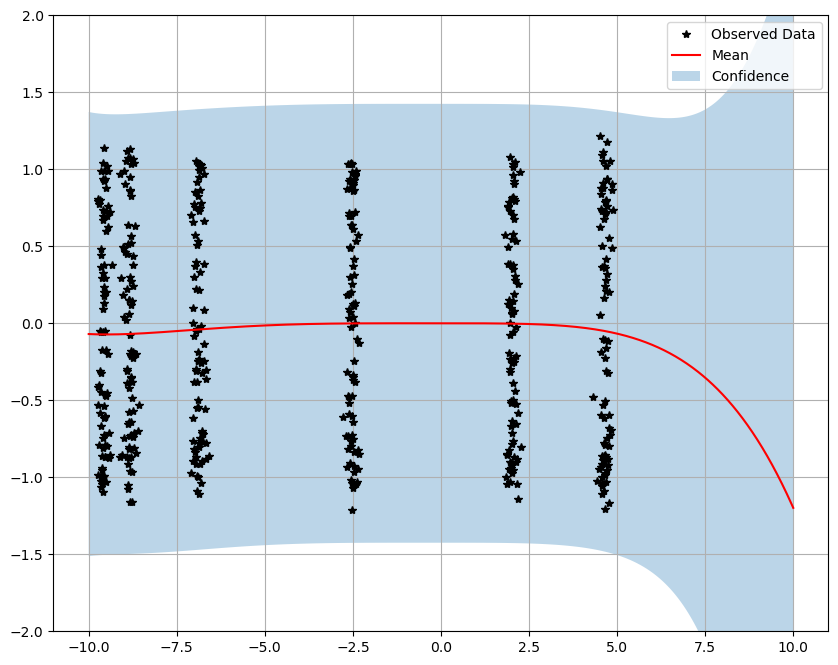

In [13]:
# Plot y2 (high freq sine wave)
plt.figure(figsize=(10, 8))
plt.plot(x_train.numpy(), y_train[:, 1].numpy(), 'k*')
plt.plot(x_test, y_means[:, 1], 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test, y_means[:, 1] - 2 * y_stds[:, 1], y_means[:, 1] + 2 * y_stds[:, 1], alpha=0.3)
plt.ylim([-2, 2])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

## View BLR Model Parameters

In [14]:
# Pass the test data through the model
for i, model in enumerate(blr_model_sin1.estimators_):
    print(f"Model {i + 1}")
    print(f"Alpha (Estimated precision of the noise): {model.alpha_}")
    print(f"Lambda (Estimated precision of the weights): {model.lambda_}")
    print(f"Score (log marginal likelihood): {model.scores_[-1]}")

Model 1
Alpha (Estimated precision of the noise): 73.28921799388496
Lambda (Estimated precision of the weights): 9.818440230379396
Score (log marginal likelihood): 318.92236455697497
Model 2
Alpha (Estimated precision of the noise): 1.9699897334851622
Lambda (Estimated precision of the weights): 1380154.9040309875
Score (log marginal likelihood): -550.1094975329625


# TEST 1b: 2 Separate Sinusoids Test - Equally Spaced Sampling

## Setup Dataset

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import gpytorch

# Define USER parameters for dataset
low_freq = 0.1 # Hz
high_freq = 100 # Hz
n_samples = 500

# Setup equally spaced input data
x_train = torch.linspace(-10, 10, n_samples)

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.5, n_samples)
y1_low_freq = torch.sin(2 * torch.pi * low_freq * x_train) + torch.Tensor(gw_noise)
y2_high_freq = torch.sin(2 * torch.pi * high_freq * x_train) + torch.Tensor(gw_noise)
y_train = torch.stack([y1_low_freq, y2_high_freq], -1)

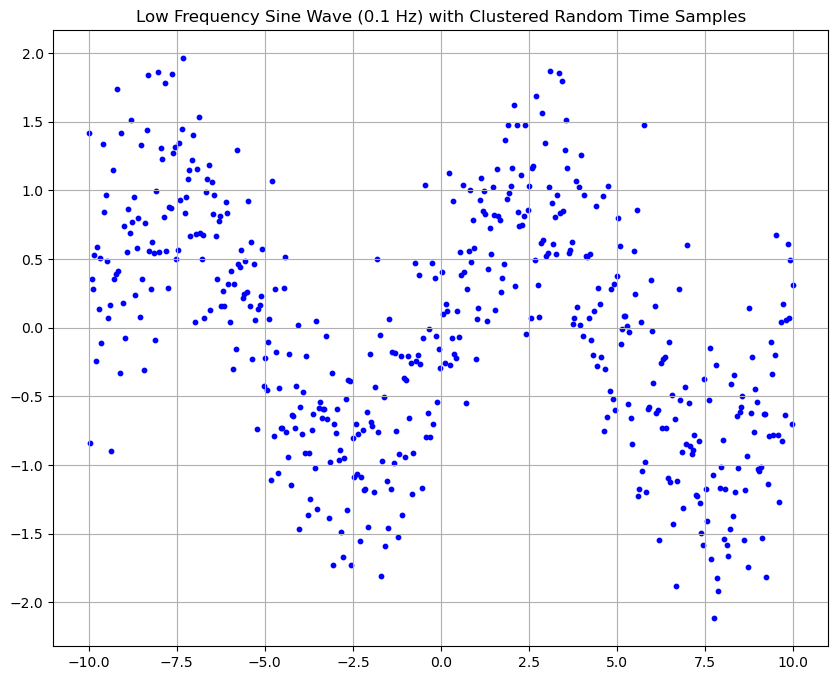

In [16]:
# Plot low frequency sine wave
plt.figure(figsize=(10, 8))
plt.scatter(x_train, y1_low_freq, color='blue', s=10)
plt.title(f'Low Frequency Sine Wave ({low_freq} Hz) with Clustered Random Time Samples')
plt.grid(True)
plt.show()

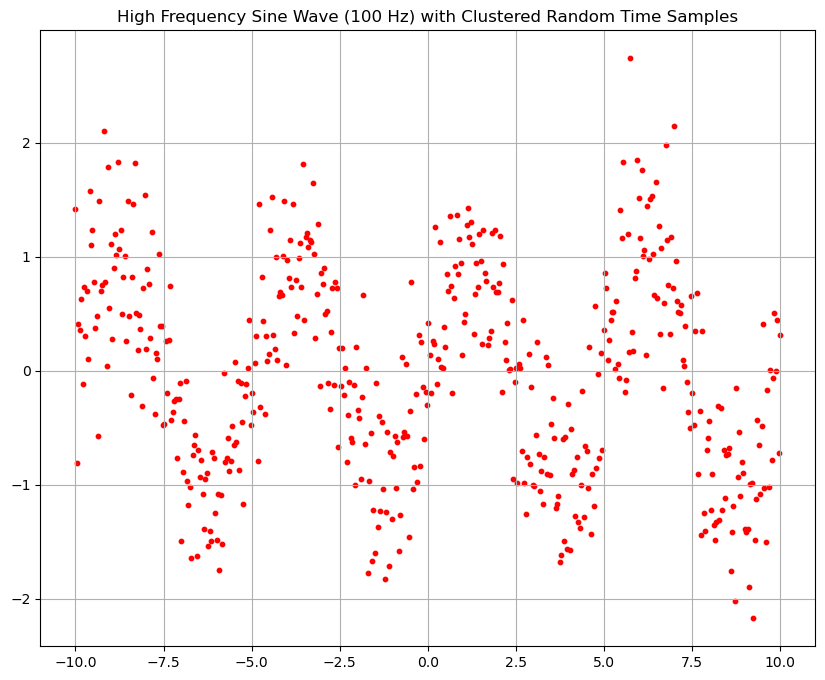

In [17]:
# Plot high frequency sine wave in a separate figure
plt.figure(figsize=(10, 8))
plt.scatter(x_train, y2_high_freq, color='red', s=10)
plt.title(f'High Frequency Sine Wave ({high_freq} Hz) with Clustered Random Time Samples')
plt.grid(True)
plt.show()

## Train the Batch GP model

In [18]:
# NOTE: Assumed that Previous section with MultitaskGPModel class has already been run
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model_sin2 = BatchIndependentMultitaskGPModel(x_train, y_train, likelihood)

# Find optimal model hyperparameters
model_sin2.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model_sin2.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_sin2)

training_epochs = 250
for i in range(training_epochs):
    optimizer.zero_grad()
    output = model_sin2(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_epochs, loss.item()))
    optimizer.step()

Iter 1/250 - Loss: 1.239
Iter 2/250 - Loss: 1.211
Iter 3/250 - Loss: 1.180
Iter 4/250 - Loss: 1.147
Iter 5/250 - Loss: 1.116
Iter 6/250 - Loss: 1.088
Iter 7/250 - Loss: 1.058
Iter 8/250 - Loss: 1.025
Iter 9/250 - Loss: 1.001
Iter 10/250 - Loss: 0.975
Iter 11/250 - Loss: 0.947
Iter 12/250 - Loss: 0.926
Iter 13/250 - Loss: 0.911
Iter 14/250 - Loss: 0.889
Iter 15/250 - Loss: 0.864
Iter 16/250 - Loss: 0.849
Iter 17/250 - Loss: 0.837
Iter 18/250 - Loss: 0.829
Iter 19/250 - Loss: 0.824
Iter 20/250 - Loss: 0.812
Iter 21/250 - Loss: 0.812
Iter 22/250 - Loss: 0.816
Iter 23/250 - Loss: 0.819
Iter 24/250 - Loss: 0.824
Iter 25/250 - Loss: 0.838
Iter 26/250 - Loss: 0.824
Iter 27/250 - Loss: 0.829
Iter 28/250 - Loss: 0.837
Iter 29/250 - Loss: 0.837
Iter 30/250 - Loss: 0.835
Iter 31/250 - Loss: 0.831
Iter 32/250 - Loss: 0.831
Iter 33/250 - Loss: 0.821
Iter 34/250 - Loss: 0.816
Iter 35/250 - Loss: 0.817
Iter 36/250 - Loss: 0.812
Iter 37/250 - Loss: 0.816
Iter 38/250 - Loss: 0.816
Iter 39/250 - Loss: 0

## Make predictions with the GP model and Plot it

In [19]:
# Set into eval mode
model_sin2.eval()
likelihood.eval()

# Make predictions
# IMP NOTE:    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x_test = torch.linspace(-10, 10, 1000)
    predictions = likelihood(model_sin2(x_test))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

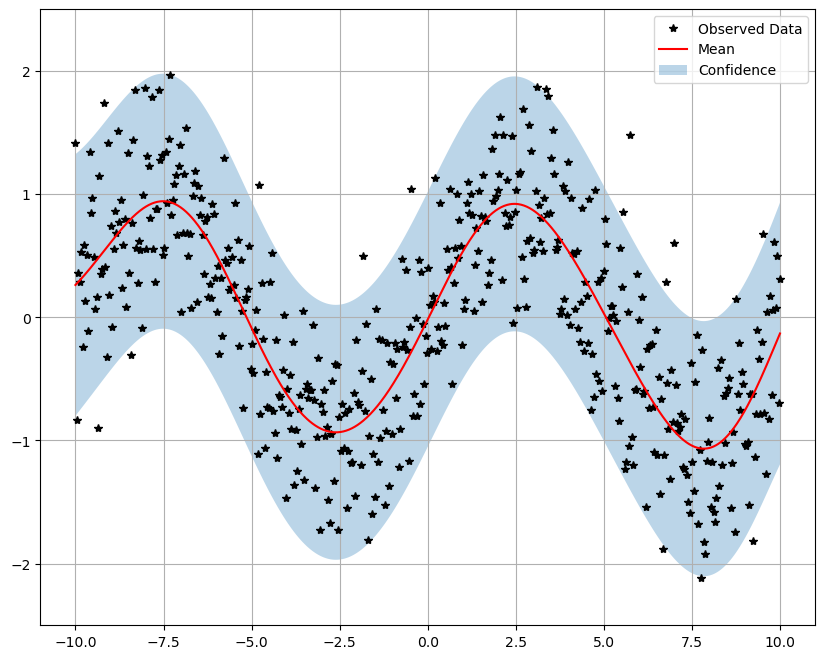

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(x_train.detach().numpy(), y_train[:, 0].detach().numpy(), 'k*')
plt.plot(x_test.numpy(), mean[:, 0].numpy(), 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.3)
plt.ylim([-2.5, 2.5])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

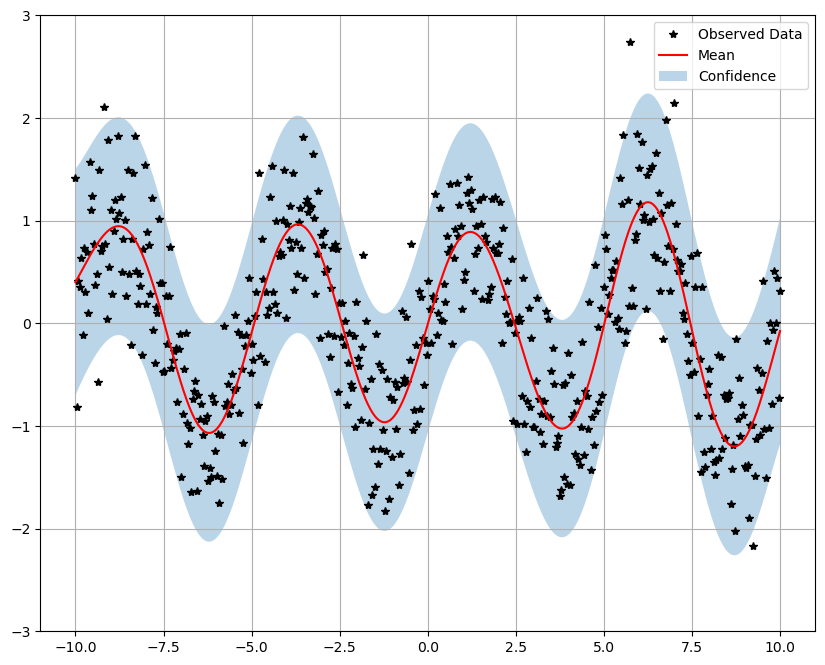

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(x_train.detach().numpy(), y_train[:, 1].detach().numpy(), 'k*')
plt.plot(x_test.numpy(), mean[:, 1].numpy(), 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.3)
plt.ylim([-3, 3])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

## View Model Parameters

In [22]:
for name, param in model_sin2.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter value: {param}\n")

Parameter name: likelihood.raw_task_noises
Parameter value: Parameter containing:
tensor([-1.9857, -1.9101], requires_grad=True)

Parameter name: likelihood.raw_noise
Parameter value: Parameter containing:
tensor([-1.9429], requires_grad=True)

Parameter name: mean_module.raw_constant
Parameter value: Parameter containing:
tensor([0.1188, 0.0809], requires_grad=True)

Parameter name: covar_module.raw_outputscale
Parameter value: Parameter containing:
tensor([-0.1146,  0.8485], requires_grad=True)

Parameter name: covar_module.base_kernel.raw_lengthscale
Parameter value: Parameter containing:
tensor([[[2.2399]],

        [[1.1870]]], requires_grad=True)



## Define and Fit the BLR Model

In [23]:
from sklearn.linear_model import BayesianRidge
from sklearn.multioutput import MultiOutputRegressor
import numpy as np

n_order = 5 # order for polynomial features
x_test = np.linspace(-10, 10, 1000)

# Create datasets with polynomial features
x_train_blr = np.vander(x_train.numpy(), n_order + 1, increasing=True)
x_test_blr = np.vander(x_test, n_order + 1, increasing=True)
blr_model_sin2 = MultiOutputRegressor(BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True))
# blr_model_sin2.estimator.set_params(alpha_init=1.0, lambda_init=0.001) # Had no effect

# Fit the model
blr_model_sin2.fit(x_train_blr, y_train.numpy())

MultiOutputRegressor(estimator=BayesianRidge(compute_score=True,
                                             fit_intercept=False, tol=1e-06))

## Make predictions with the BLR model and Plot it

In [24]:
# NOTE: Multi-output regressor doesn't support return_std, so have to pass test data into model through a loop
# Collect the mean and standard deviation for each output
y_means = np.zeros((x_test_blr.shape[0], 2))
y_stds = np.zeros((x_test_blr.shape[0], 2))

# Pass the test data through the model
for i, model in enumerate(blr_model_sin2.estimators_):
    y_mean, y_std = model.predict(x_test_blr, return_std=True)
    y_means[:, i] = y_mean
    y_stds[:, i] = y_std

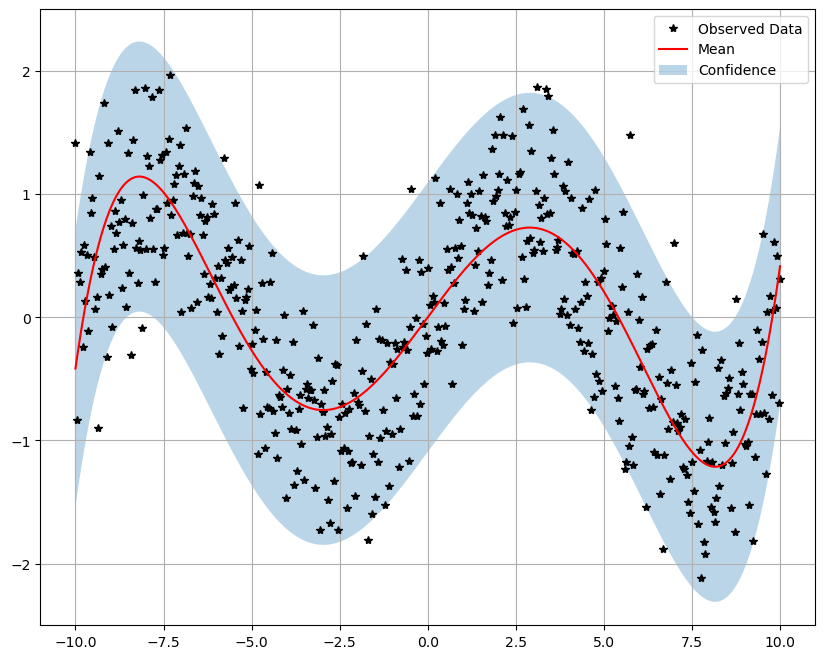

In [25]:
# Plot y1 (low freq sine wave) 
plt.figure(figsize=(10, 8))
plt.plot(x_train.numpy(), y_train[:, 0].numpy(), 'k*')
plt.plot(x_test, y_means[:, 0], 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test, y_means[:, 0] - 2 * y_stds[:, 0], y_means[:, 0] + 2 * y_stds[:, 0], alpha=0.3)
plt.ylim([-2.5, 2.5])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

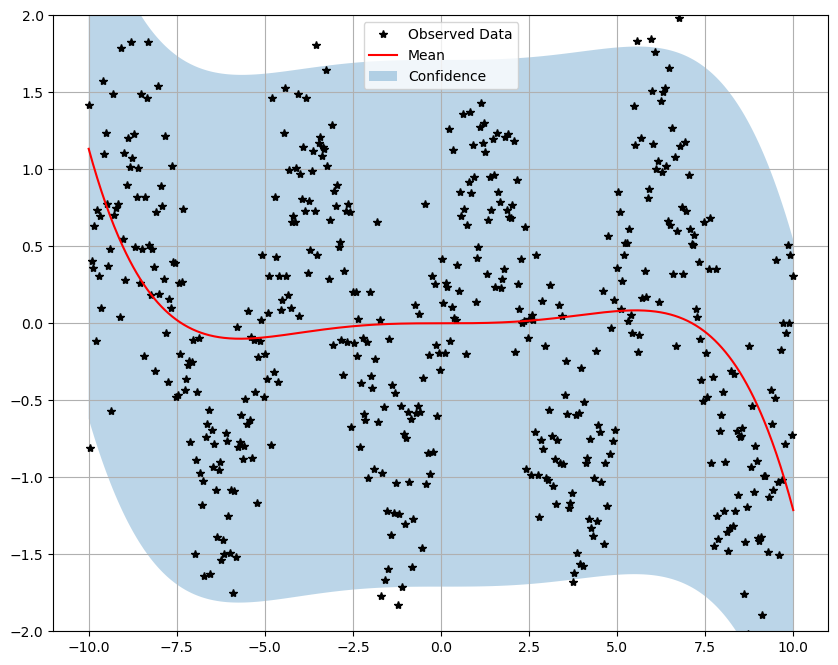

In [26]:
# Plot y2 (high freq sine wave)
plt.figure(figsize=(10, 8))
plt.plot(x_train.numpy(), y_train[:, 1].numpy(), 'k*')
plt.plot(x_test, y_means[:, 1], 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test, y_means[:, 1] - 2 * y_stds[:, 1], y_means[:, 1] + 2 * y_stds[:, 1], alpha=0.3)
plt.ylim([-2, 2])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

## View BLR Model Parameters

In [27]:
# Pass the test data through the model
for i, model in enumerate(blr_model_sin2.estimators_):
    print(f"Model {i + 1}")
    print(f"Alpha (Estimated precision of the noise): {model.alpha_}")
    print(f"Lambda (Estimated precision of the weights): {model.lambda_}")
    print(f"Score (log marginal likelihood): {model.scores_[-1]}")

Model 1
Alpha (Estimated precision of the noise): 3.3701339213223487
Lambda (Estimated precision of the weights): 38.97280010599402
Score (log marginal likelihood): -442.15975389297006
Model 2
Alpha (Estimated precision of the noise): 1.3677583115290912
Lambda (Estimated precision of the weights): 801443.9302432638
Score (log marginal likelihood): -643.6001122617347


# TEST 2: Discontinuity Test

## Setup the dataset

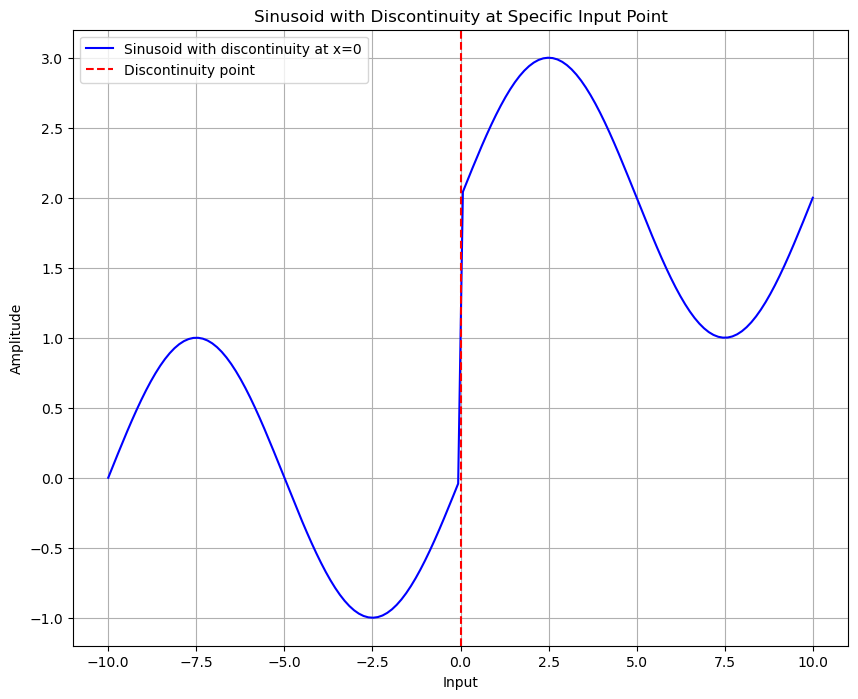

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# USER Parameters for the sinusoid
freq_sine = 0.1 # Hz
vertical_shift = 2.0 # Vertical shift applied to sine after jump
n_samples = 150
jump_point = 0 # Input point where the discontinuity occurs

# Create input and sine wave w/ jump
x_train = np.linspace(-10, 10, n_samples)
y_train = np.sin(2 * np.pi * freq_sine * x_train)
y_train[x_train >= jump_point] = vertical_shift + np.sin(2 * np.pi * freq_sine * x_train[x_train >= jump_point])

# Plot
plt.figure(figsize=(10, 8))
plt.plot(x_train, y_train, label=f'Sinusoid with discontinuity at x={jump_point}', color='b')
plt.axvline(x=jump_point, color='r', linestyle='--', label='Discontinuity point')
plt.title('Sinusoid with Discontinuity at Specific Input Point')
plt.xlabel('Input')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

## Define and Train the GP model

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from gp_extras.kernels import LocalLengthScalesKernel

# Define custom optimizer for hyperparameter-tuning of non-stationary kernel
def de_optimizer(obj_func, initial_theta, bounds):
    res = differential_evolution(lambda x: obj_func(x, eval_gradient=False),
                                 bounds, maxiter=20, disp=False, polish=False)
    return res.x, obj_func(res.x, eval_gradient=False)

kernel_lls = C(1.0, (1e-10, 1000)) * LocalLengthScalesKernel.construct(x_train[:, np.newaxis], l_L=0.1, l_U=2.0, l_samples=5)
gp_lls = GaussianProcessRegressor(kernel=kernel_lls, optimizer=de_optimizer)
gp_lls.fit(x_train[:, np.newaxis], y_train[:, np.newaxis])

GaussianProcessRegressor(kernel=1**2 * LocalLengthScalesKernel(theta_gp=[0.1], theta_l=[0.1], length_scales=[1. 1. 1. 1. 1.]),
                         optimizer=<function de_optimizer at 0x148079120>)

## Make predictions with the GP model and Plot it

In [30]:
x_test = np.linspace(-10, 10, 1000)
y_mean_lls, y_std_lls = gp_lls.predict(x_test[:, np.newaxis], return_std=True)

/Users/lancepharand/ENTER/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:479: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


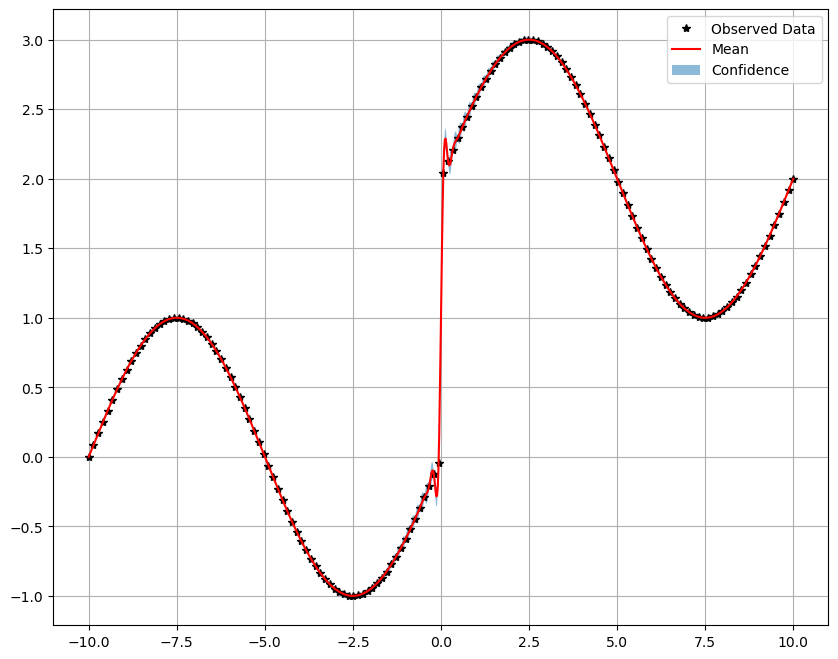

In [31]:
# Plot
plt.figure(figsize=(10, 8))
plt.plot(x_train, y_train, 'k*') # Training data
plt.plot(x_test, y_mean_lls, 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test, y_mean_lls - 2 * y_std_lls, y_mean_lls + 2 * y_std_lls, alpha=0.5)
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

## View GP Model Parameters

In [32]:
print(f"Learned kernel LLS: {gp_lls.kernel_}")
print(f"Log-marginal-likelihood LLS: {gp_lls.log_marginal_likelihood(gp_lls.kernel_.theta)}")

Learned kernel LLS: 2.11**2 * LocalLengthScalesKernel(theta_gp=[0.00322558], theta_l=[3.42929561], length_scales=[1.75056075 1.17674961 0.10739564 0.48742832 1.94016905])
Log-marginal-likelihood LLS: 379.67105780693737


## Define and Fit the BLR Model

In [33]:
from sklearn.linear_model import BayesianRidge
import numpy as np

n_order = 5 # order for polynomial features

# Create datasets with polynomial features
x_train_blr = np.vander(x_train, n_order + 1, increasing=True)
x_test_blr = np.vander(x_test, n_order + 1, increasing=True)
blr_model_sin_disc = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
# blr_model_sin2.estimator.set_params(alpha_init=1.0, lambda_init=0.001) # Had no effect

# Fit the model
blr_model_sin_disc.fit(x_train_blr, y_train)

BayesianRidge(compute_score=True, fit_intercept=False, tol=1e-06)

## Make predictions with the BLR model and Plot it

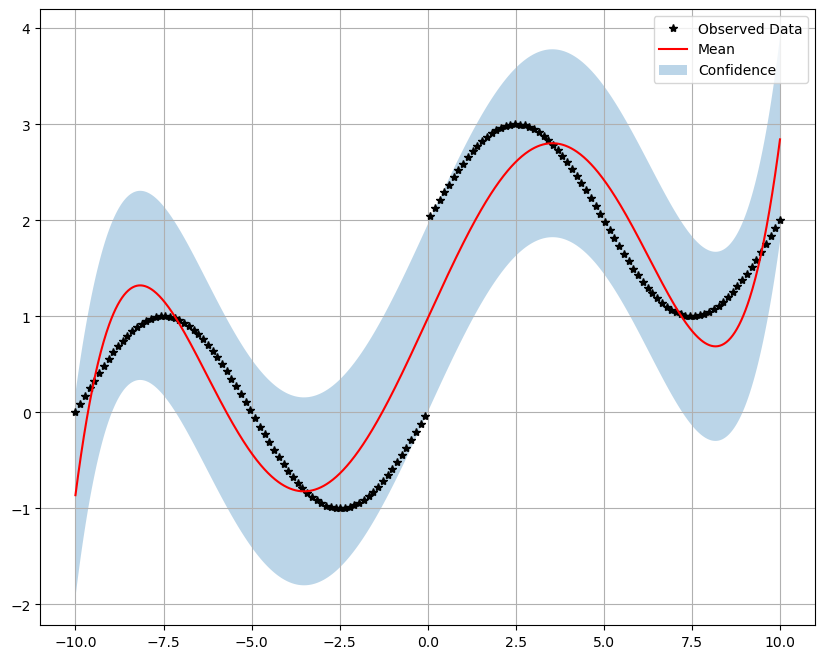

In [34]:
y_means, y_stds = blr_model_sin_disc.predict(x_test_blr, return_std=True)

# Plot 
plt.figure(figsize=(10, 8))
plt.plot(x_train, y_train, 'k*') # Training data
plt.plot(x_test, y_means, 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test, y_means - 2 * y_stds, y_means + 2 * y_stds, alpha=0.3)
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

## View BLR Model Parameters

In [35]:
# Pass the test data through the model
print(f"Alpha (Estimated precision of the noise): {blr_model_sin_disc.alpha_}")
print(f"Lambda (Estimated precision of the weights): {blr_model_sin_disc.lambda_}")
print(f"Score (log marginal likelihood: {blr_model_sin_disc.scores_[-1]}")

Alpha (Estimated precision of the noise): 4.295725540801461
Lambda (Estimated precision of the weights): 3.7293903266203112
Score (log marginal likelihood: -144.13791155387995


# TEST 3: Noise Variation

## Setup the dataset

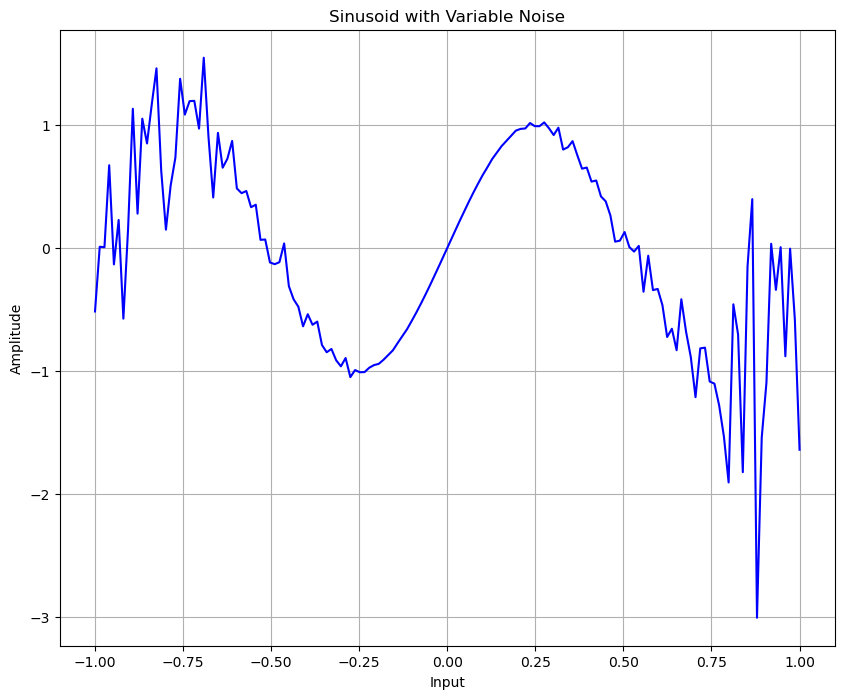

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# USER Parameters for the sinusoid
freq_sine = 1 # Hz
n_samples = 150

# Create input datasets and sine wave w/ noise variation
x_train = np.linspace(-1, 1, n_samples)
y_train = np.sin(2 * np.pi * freq_sine * x_train) + np.random.randn(n_samples) * (x_train ** 3)
x_test = np.linspace(-10, 10, 1000)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(x_train, y_train, color='b')
plt.title('Sinusoid with Variable Noise')
plt.xlabel('Input')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

## Define the GP model

In [ ]:
# Skipped for now, GP model shouldn't have trouble with this dataset

## Train the GP model

## Make predictions with the GP model and Plot it

## Define and Fit the BLR Model

In [37]:
from sklearn.linear_model import BayesianRidge
import numpy as np

n_order = 5 # order for polynomial features

# Create datasets with polynomial features
x_train_blr = np.vander(x_train, n_order + 1, increasing=True)
x_test_blr = np.vander(x_test, n_order + 1, increasing=True)
blr_model_sin_noise = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
# blr_model_sin2.estimator.set_params(alpha_init=1.0, lambda_init=0.001) # Had no effect

# Fit the model
blr_model_sin_noise.fit(x_train_blr, y_train)

BayesianRidge(compute_score=True, fit_intercept=False, tol=1e-06)

## Make predictions with the BLR model and Plot it

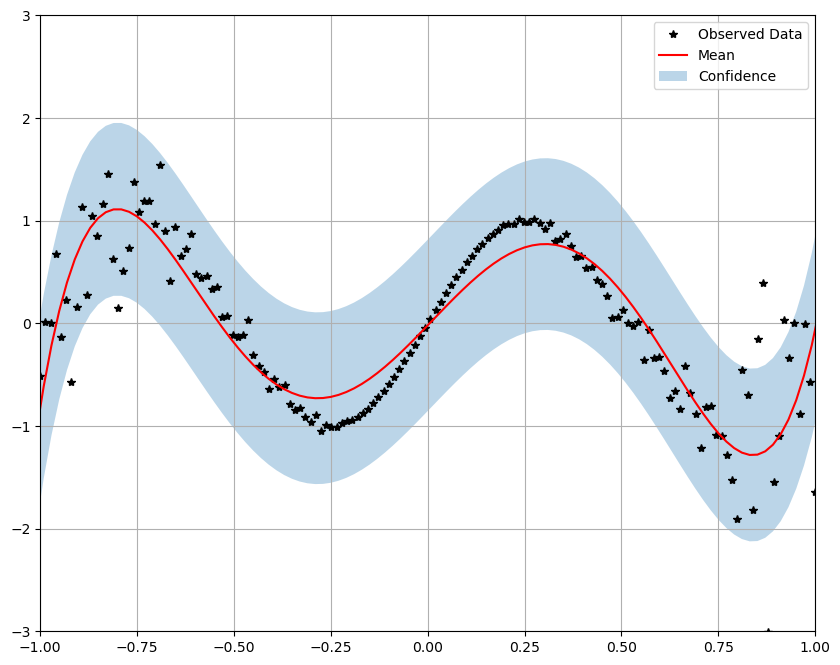

In [38]:
y_means, y_stds = blr_model_sin_noise.predict(x_test_blr, return_std=True)

# Plot 
plt.figure(figsize=(10, 8))
plt.plot(x_train, y_train, 'k*') # Training data
plt.plot(x_test, y_means, 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test, y_means - 2 * y_stds, y_means + 2 * y_stds, alpha=0.3)
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.ylim([-3, 3])
plt.xlim([-1, 1])
plt.grid(True)
plt.show()

## View BLR Model Parameters

In [39]:
# Pass the test data through the model
print(f"Alpha (Estimated precision of the noise): {blr_model_sin_noise.alpha_}")
print(f"Lambda (Estimated precision of the weights): {blr_model_sin_noise.lambda_}")
print(f"Score (log marginal likelihood: {blr_model_sin_noise.scores_[-1]}")

Alpha (Estimated precision of the noise): 5.88069219107628
Lambda (Estimated precision of the weights): 0.012107487526722114
Score (log marginal likelihood: -104.17861362584974
